In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw

In [2]:
df = pd.read_pickle('../data/df.pickle')
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [3]:
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] <= "2021-12-31")]
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] <= "2022-12-31")]
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] <= "2023-09-30")]
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] <= "2020-12-31")]

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [5]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [7]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp


In [8]:
Np = 1416

In [9]:
node_2020, edge_2020, timestamp_2020 = getNetworkAnalysis(df_2020)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)

In [15]:
# model3を用いてalpha, betaを推定
M = np.array(edge_2020)
N = np.array(node_2020)

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta)

alpha:  0.082
beta:  0.475


In [30]:
# model3を用いてalpha, betaを推定
M = np.array(edge_2021)
N = np.array(node_2021)

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta)

alpha:  0.102
beta:  1.351


In [31]:
# model3を用いてalpha, betaを推定
M = np.array(edge_2022)
N = np.array(node_2022)

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta)

alpha:  0.149
beta:  16.247


In [32]:
# model3を用いてalpha, betaを推定
M = np.array(edge_2023)
N = np.array(node_2023)

params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta)

alpha:  0.151
beta:  21.592


In [33]:
alpha_list = [0.082, 0.102, 0.149, 0.151]
beta_list = [0.475, 1.351, 16.247, 21.592]

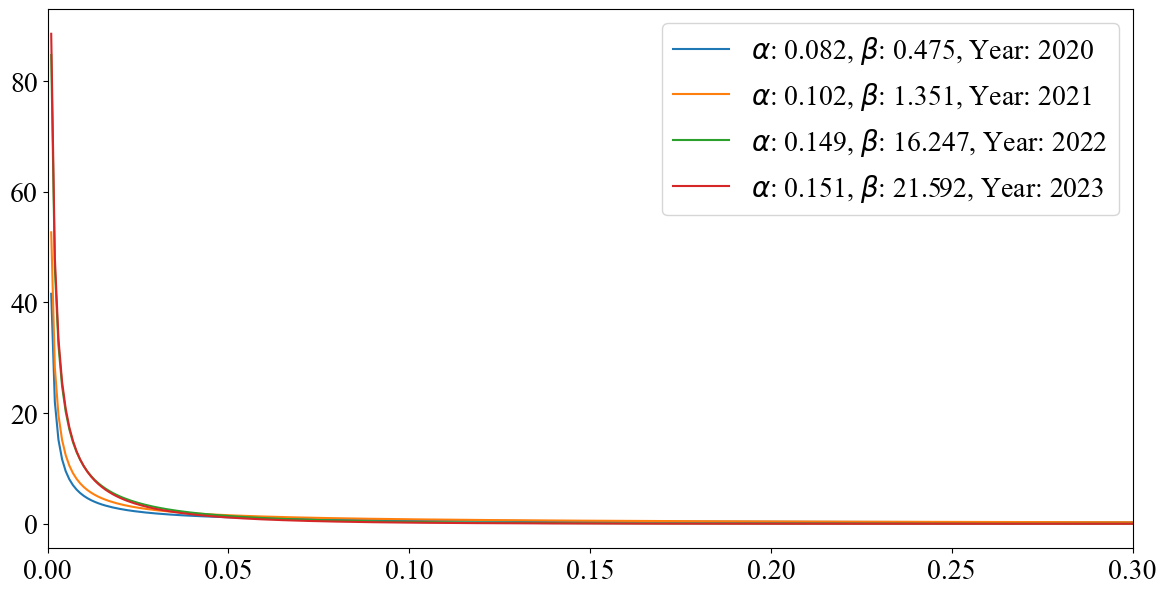

In [48]:
plt.figure(figsize=(14, 7))
a = np.linspace(0, 1, 1000)
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']

for i in range(len(alpha_list)):
    # log-log plot
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]), )

# x軸の範囲を0.4までに設定
plt.xlim(0, 0.3)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

In [50]:
from src.ex_data_analysis import fit


rho_2020 = rho(a, alpha_list[0], beta_list[0])
rho_2021 = rho(a, alpha_list[1], beta_list[1])
rho_2022 = rho(a, alpha_list[2], beta_list[2])
rho_2023 = rho(a, alpha_list[3], beta_list[3])

# power law fitting
fit_2020 = powerlaw.Fit(rho_2020)
fit_2021 = powerlaw.Fit(rho_2021)
fit_2022 = powerlaw.Fit(rho_2022)
fit_2023 = powerlaw.Fit(rho_2023)

Calculating best minimal value for power law fit


alpha:  2.314941406250002
xmin:  0.3420282651916161
sigma:  0.0794385154950278


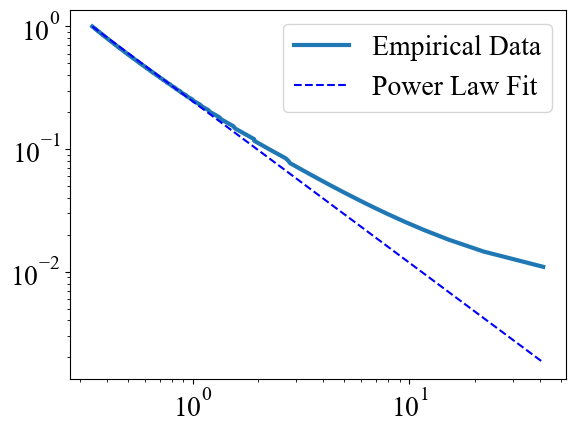

In [62]:
print("alpha: ", fit_2020.alpha)
print("xmin: ", fit_2020.xmin)
print("sigma: ", fit_2020.sigma)

# fit_2020.plot_ccdf(color='b', linewidth=2)

# fit_2021.plot_ccdf(color='r', linewidth=2)
fig = fit_2020.plot_ccdf(linewidth=3, label='Empirical Data')
fit_2020.power_law.plot_ccdf(ax=fig, color='b', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
alpha:  2.088378906250002
xmin:  0.44423607111441527
sigma:  0.07916791623307748


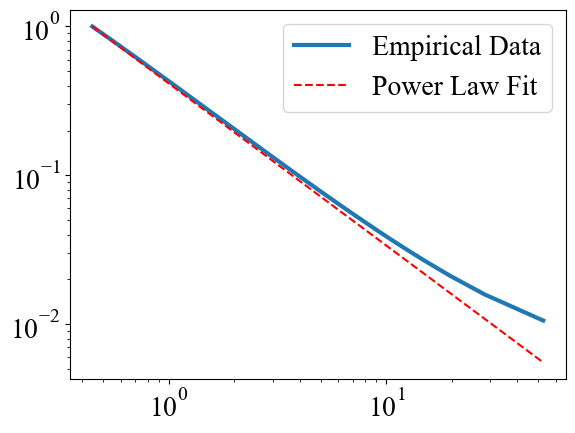

In [59]:
fit_2021 = powerlaw.Fit(rho_2021)

print("alpha: ", fit_2021.alpha)
print("xmin: ", fit_2021.xmin)
print("sigma: ", fit_2021.sigma)

# fit_2021.plot_ccdf(color='r', linewidth=2)
fig = fit_2021.plot_ccdf(linewidth=3, label='Empirical Data')
fit_2021.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
alpha:  1.926464843750002
xmin:  2.1541339528377637
sigma:  0.14835310499500634


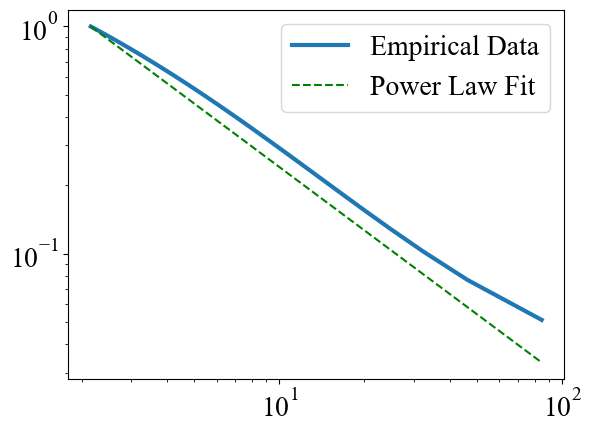

In [63]:
fit_2022 = powerlaw.Fit(rho_2022)

print("alpha: ", fit_2022.alpha)
print("xmin: ", fit_2022.xmin)
print("sigma: ", fit_2022.sigma)

# fit_2022.plot_ccdf(color='g', linewidth=2)
# fit_2021.plot_ccdf(color='r', linewidth=2)
fig = fit_2022.plot_ccdf(linewidth=3, label='Empirical Data')
fit_2022.power_law.plot_ccdf(ax=fig, color='g', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
alpha:  1.875292968750002
xmin:  2.1192928922467322
sigma:  0.14588216145833366


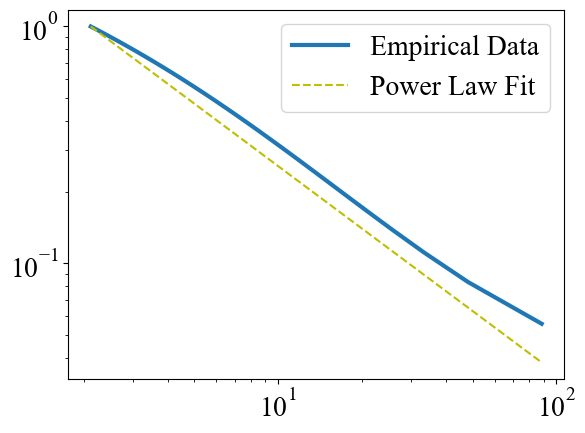

In [61]:
fit_2023 = powerlaw.Fit(rho_2023)

print("alpha: ", fit_2023.alpha)
print("xmin: ", fit_2023.xmin)
print("sigma: ", fit_2023.sigma)

# fit_2023.plot_ccdf(color='y', linewidth=2, original_data=True)
# fit_2021.plot_ccdf(color='r', linewidth=2)
fig = fit_2023.plot_ccdf(linewidth=3, label='Empirical Data')
fit_2023.power_law.plot_ccdf(ax=fig, color='y', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})

In [65]:
print(len(node_2020))
print(len(node_2021))
print(len(node_2022))
print(len(node_2023))

274
364
364
272


In [66]:
print(len(edge_2020)) 
print(len(edge_2021))
print(len(edge_2022))
print(len(edge_2023))

274
364
364
272


In [67]:
# 各dfの数を確認
print(len(df_2020))
print(len(df_2021))
print(len(df_2022))
print(len(df_2023))


2960202
4583613
4365599
3465125
